In [5]:
import pandas as pd
from matplotlib import pyplot as plt
import category_encoders as ce
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import shap

In [6]:
data = pd.read_csv('./data/data.csv')
data

,Area,Year,Food Inflation Rate,Raw GDP,GDP Growth Rate,Item,Item Price Per Tonne,Overall Inflation Rate
0,Albania,2012,2.404087,12319.779604,-4.430218,Apples,369.7,3.2
1,Albania,2012,2.404087,12319.779604,-4.430218,Apricots,489.9,3.2
2,Albania,2012,2.404087,12319.779604,-4.430218,Barley,316.1,3.2
3,Albania,2012,2.404087,12319.779604,-4.430218,"Beans, dry",1562.2,3.2
4,Albania,2012,2.404087,12319.779604,-4.430218,Cabbages,203.4,3.2
...,...,...,...,...,...,...,...,...
15644,Switzerland,2022,1.661019,818426.550206,0.616880,Tomatoes,3407.9,2.7
15645,Switzerland,2022,1.661019,818426.550206,0.616880,Triticale,362.4,2.7
15646,Switzerland,2022,1.661019,818426.550206,0.616880,Unmanufactured tobacco,16495.0,2.7
15647,Switzerland,2022,1.661019,818426.550206,0.616880,"Walnuts, in shell",3498.0,2.7


In [7]:
data['Difference of inflation'] = data['Food Inflation Rate'] - data['Overall Inflation Rate']

In [8]:
mean_value = data['Difference of inflation'].mean()
std_dev = data['Difference of inflation'].std()
mean_value, std_dev

(0.6515898678563061, 1.8824104304769325)

In [9]:
threshold = mean_value + std_dev

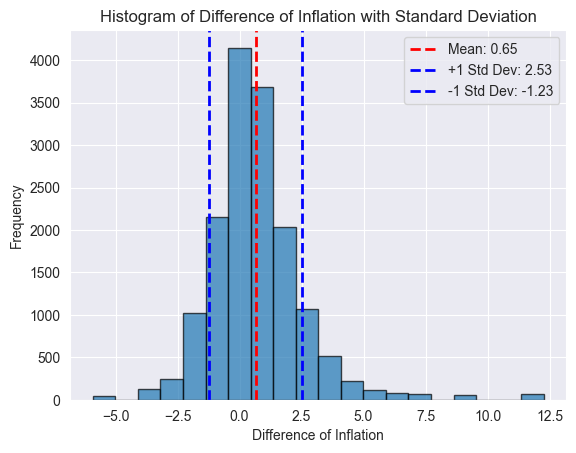

In [10]:
plt.hist(data['Difference of inflation'], bins=20, edgecolor='black', alpha=0.7)

plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(mean_value + std_dev, color='blue', linestyle='dashed', linewidth=2,
            label=f'+1 Std Dev: {mean_value + std_dev:.2f}')
plt.axvline(mean_value - std_dev, color='blue', linestyle='dashed', linewidth=2,
            label=f'-1 Std Dev: {mean_value - std_dev:.2f}')

plt.title('Histogram of Difference of Inflation with Standard Deviation')
plt.xlabel('Difference of Inflation')
plt.ylabel('Frequency')

plt.legend()

plt.show()

In [11]:
data['label'] = data['Difference of inflation'].apply(lambda x: 1 if x > threshold else 0)

In [12]:
data

,Area,Year,Food Inflation Rate,Raw GDP,GDP Growth Rate,Item,Item Price Per Tonne,Overall Inflation Rate,Difference of inflation,label
0,Albania,2012,2.404087,12319.779604,-4.430218,Apples,369.7,3.2,-0.795913,0
1,Albania,2012,2.404087,12319.779604,-4.430218,Apricots,489.9,3.2,-0.795913,0
2,Albania,2012,2.404087,12319.779604,-4.430218,Barley,316.1,3.2,-0.795913,0
3,Albania,2012,2.404087,12319.779604,-4.430218,"Beans, dry",1562.2,3.2,-0.795913,0
4,Albania,2012,2.404087,12319.779604,-4.430218,Cabbages,203.4,3.2,-0.795913,0
...,...,...,...,...,...,...,...,...,...,...
15644,Switzerland,2022,1.661019,818426.550206,0.616880,Tomatoes,3407.9,2.7,-1.038981,0
15645,Switzerland,2022,1.661019,818426.550206,0.616880,Triticale,362.4,2.7,-1.038981,0
15646,Switzerland,2022,1.661019,818426.550206,0.616880,Unmanufactured tobacco,16495.0,2.7,-1.038981,0
15647,Switzerland,2022,1.661019,818426.550206,0.616880,"Walnuts, in shell",3498.0,2.7,-1.038981,0


In [13]:
numerical_columns=['Food Inflation Rate', 'Raw GDP', 'GDP Growth Rate','Item Price Per Tonne', 'Overall Inflation Rate', 'Difference of inflation']

In [14]:
binary_encoder2 = ce.BinaryEncoder(cols=['Item', 'Area'])
data_supervised = binary_encoder2.fit_transform(data)

In [15]:
scaler2 = RobustScaler()
data_supervised[numerical_columns] = scaler2.fit_transform(data_supervised[numerical_columns])

C:\Users\Tamara\venv\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\Tamara\venv\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Tamara\venv\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Tamara\venv\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(ar

In [16]:
data_supervised

,Area_0,Area_1,Area_2,Area_3,Area_4,Year,Food Inflation Rate,Raw GDP,GDP Growth Rate,Item_0,...,Item_2,Item_3,Item_4,Item_5,Item_6,Item_7,Item Price Per Tonne,Overall Inflation Rate,Difference of inflation,label
0,0,0,0,0,1,2012,0.160705,-0.422628,-0.784202,0,...,0,0,0,0,0,1,-0.299190,0.708333,-0.704691,0
1,0,0,0,0,1,2012,0.160705,-0.422628,-0.784202,0,...,0,0,0,0,1,0,-0.229156,0.708333,-0.704691,0
2,0,0,0,0,1,2012,0.160705,-0.422628,-0.784202,0,...,0,0,0,0,1,1,-0.330420,0.708333,-0.704691,0
3,0,0,0,0,1,2012,0.160705,-0.422628,-0.784202,0,...,0,0,0,1,0,0,0.395618,0.708333,-0.704691,0
4,0,0,0,0,1,2012,0.160705,-0.422628,-0.784202,0,...,0,0,0,1,0,1,-0.396085,0.708333,-0.704691,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15644,1,1,1,1,1,2022,-0.104060,1.261023,-0.232093,0,...,1,1,1,0,0,0,1.471013,0.500000,-0.840933,0
15645,1,1,1,1,1,2022,-0.104060,1.261023,-0.232093,0,...,0,1,0,1,0,1,-0.303443,0.500000,-0.840933,0
15646,1,1,1,1,1,2022,-0.104060,1.261023,-0.232093,0,...,1,1,1,0,0,1,9.096195,0.500000,-0.840933,0
15647,1,1,1,1,1,2022,-0.104060,1.261023,-0.232093,0,...,0,1,0,1,1,0,1.523510,0.500000,-0.840933,0


In [38]:
X, Y = data_supervised.drop(columns=['label']), data_supervised['label']

# skf = StratifiedKFold(n_splits=5)
# for train_index, test_index in skf.split(X, Y):
#     x_train, x_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
#
#     classifier2 = RandomForestClassifier(n_estimators=15, max_depth=2)
#     classifier2.fit(x_train, y_train)
#     y_pred = classifier2.predict(x_test)
#     print(classification_report(y_pred, y_test))

classifier = RandomForestClassifier(
    n_estimators=10,  # Number of trees
    max_depth=2,  # Maximum depth of each tree
    min_samples_split=10,  # Minimum samples required to split a node
    min_samples_leaf=2,  # Minimum samples required at each leaf node
    max_features='sqrt',  # Number of features to consider at each split
    # class_weight='balanced',  # Automatically adjust class weights
    random_state=42  # Reproducibility
)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
classifier.fit(x_train, y_train)
y_pred2 = classifier.predict(x_test)
print(classification_report(y_pred2, y_test))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      2825
           1       0.78      1.00      0.88       305

    accuracy                           0.97      3130
   macro avg       0.89      0.98      0.93      3130
weighted avg       0.98      0.97      0.97      3130



C:\Users\Tamara\venv\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\Tamara\venv\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Tamara\venv\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Tamara\venv\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_d

In [39]:
y_test.value_counts()

label
0    2738
1     392
Name: count, dtype: int64

In [40]:
x_train

,Area_0,Area_1,Area_2,Area_3,Area_4,Year,Food Inflation Rate,Raw GDP,GDP Growth Rate,Item_0,Item_1,Item_2,Item_3,Item_4,Item_5,Item_6,Item_7,Item Price Per Tonne,Overall Inflation Rate,Difference of inflation
5488,0,1,0,1,1,2022,3.769990,8.066787,-0.814968,0,1,1,1,0,0,0,0,4.287421,3.000000,1.890201
5073,0,1,0,1,1,2016,-0.407385,6.793928,0.063068,0,0,0,1,1,0,1,1,0.586319,-0.458333,-0.028915
2025,0,0,1,0,0,2017,0.725553,-0.324781,0.762966,0,1,0,0,1,1,0,1,0.310494,-0.125000,1.304881
2797,0,0,1,0,1,2019,-0.737447,-0.317881,-0.299354,0,0,1,0,0,0,0,0,1.349123,-0.291667,-0.772334
12062,1,1,0,0,1,2021,0.461520,0.148590,1.199577,0,0,0,1,1,1,1,1,2.990736,1.083333,-0.735943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,0,0,0,1,0,2016,-0.434359,0.377833,0.094397,0,1,0,0,1,0,0,0,4.509468,-0.208333,-0.407653
5192,0,1,0,1,1,2018,0.120399,7.852744,0.540958,0,1,0,0,0,1,1,1,1.548797,0.166667,-0.039432
12172,1,1,0,1,0,2012,1.794675,-0.357903,-1.620689,0,1,0,1,0,1,0,0,-0.484647,2.458333,-0.488466
235,0,0,0,0,1,2016,0.463761,-0.423586,0.156201,0,0,0,0,1,0,0,1,0.166929,0.708333,-0.227959


In [41]:
explainer = shap.Explainer(classifier)
shap_values = explainer.shap_values(x_test)

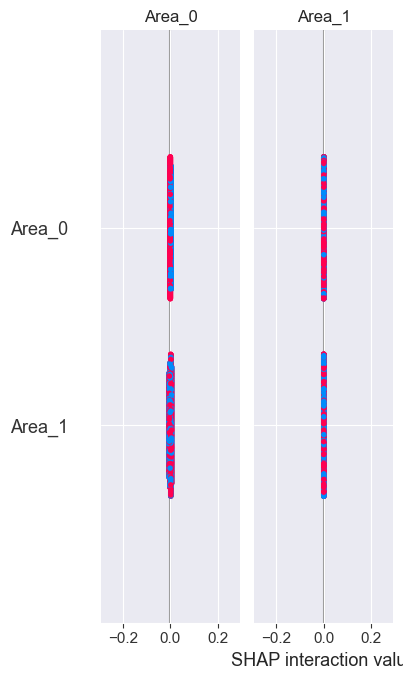

In [42]:
shap.summary_plot(shap_values, x_test)

array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [-0.00562028,  0.00562028],
       [ 0.        ,  0.        ],
       [-0.00062104,  0.00062104],
       [ 0.00866675, -0.00866675],
       [ 0.035156  , -0.035156  ],
       [-0.0090484 ,  0.0090484 ],
       [ 0.00177812, -0.00177812],
       [ 0.        ,  0.        ],
       [ 0.00019111, -0.00019111],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [-0.00090369,  0.00090369],
       [ 0.04041103, -0.04041103]])

In [28]:
shap_values[1]

array([0., 0.])

In [21]:
background_data = shap.sample(x_train, 10)
# background_data = shap.kmeans(x_train2, 10)
explainer = shap.KernelExplainer(classifier.predict_proba, background_data)
shap_values = explainer.shap_values(x_test)
shap.force_plot(explainer.expected_value[0], shap_values[..., 0], x_test)

  0%|          | 0/3130 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
for name in x_train.columns:
    shap.dependence_plot(name, shap_values, X, display_features=X_display)